# PROBLEM SET 4: 
# NEURAL NETWORKS PART TWO

<br>
<br>
<br>

# PROBLEM 1 (40%)

In the lecture notebook we discussed how a neural network autoencoder trained with respect to the mean squared error objective function and no non-linearity can reproduce PCA. In this problem we want to show this explicitly. First, take the 0 and 1 digits from the sklearn digits dataset. 

In [1]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()

from sklearn.datasets import load_digits
digits = load_digits()
selector = digits.target<2
X = digits.data[selector]
Y = digits.target[selector]

Next, apply PCA to the dataset (ignoring the digit labels) and plot the resulting dimensional reduction down to $d=2$ (i.e. the projection onto the two leading principal components). Label each datapoint according to its digit label (e.g. red and blue). So far this is just reproducing what we've already done in the lecture notebook. But now we want to reproduce the same plot (or at least a very similar plot) using a neural network autoencoder. To do this you should do the following steps:

- use the FunctionApproximator class to train a neural network with the output vectors ($y_i$) equal to the correspoding input vectors ($x_i$), i.e. $y_i = x_i$ for all $i$ 


- use only two hidden units (this way we'll only get the two leading principal components) and set the activation function (i.e. the non-linearity) to none ('activation=None' as an argument to FunctionApproximator); note that the cost function is the mean squared error by default so we don't need to specify that explicitly


- use the get_y_pred() function in FunctionApproximator to get the vectors outputted by the neural network on the input vectors; note that although these predicted vectors are 64 dimensional they all in fact live in a 2-dimensional subspace, since they all had to pass through the 2 hidden units


- run PCA on these predicted output vectors and plot the transformed dataset by projecting onto the two leading principal components (basically this will just find the relevant two-dimensional subspace within the set of output vectors; the 'actual' PCA was done by the autoencoder it's just that we use the PCA class to easily identify the subspace that the autoencoder has chosen)


- plot the 'classical' PCA result next to the 'autoencoder' PCA result and comment briefly on the degree to which they are the same (make sure you've trained the neural network reasonably well; and note that the results may differ by a sign so you may want to transform the autoencoder result by a sign change to make things more directly comparable)

In [2]:
from sklearn.decomposition import PCA
from function_approximator import FunctionApproximator

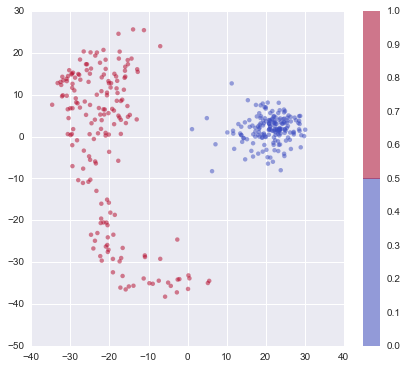

In [3]:
pca = PCA(n_components=2)
Xproj = pca.fit_transform(X)
figure, ax = plt.subplots(figsize=(7,6))
s = ax.scatter(Xproj[:, 0], Xproj[:, 1], c=Y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
figure.colorbar(s, ax=ax)

In [11]:
fa = FunctionApproximator(n_in=64, n_out=64, n_hidden=2, activation=None)
fa.train(X, X, learning_rate=0.015, n_epochs=300000, report_frequency=20000)

epoch: 20000  cost: 9.150009
epoch: 40000  cost: 8.744039
epoch: 60000  cost: 8.276309
epoch: 80000  cost: 7.836384
epoch: 100000  cost: 7.490260
epoch: 120000  cost: 7.295767
epoch: 140000  cost: 7.211059
epoch: 160000  cost: 7.174612
epoch: 180000  cost: 7.152987
epoch: 200000  cost: 7.138077
epoch: 220000  cost: 7.126515
epoch: 240000  cost: 7.117191
epoch: 260000  cost: 7.109614
epoch: 280000  cost: 7.103459
epoch: 300000  cost: 7.098462


In [12]:
y_pred = fa.get_y_pred()

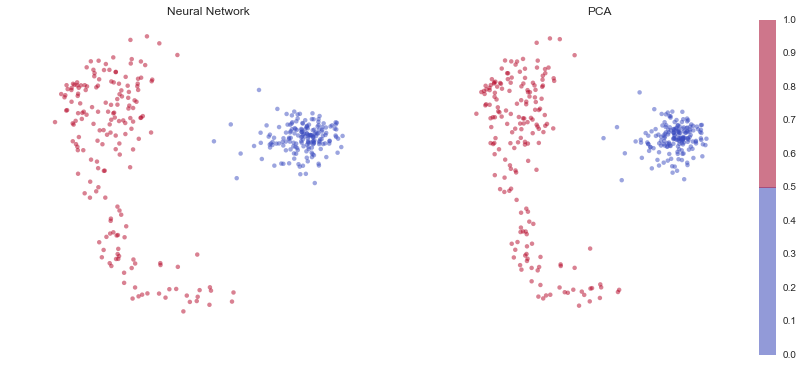

In [15]:
fig, ((ax1, ax2)) = plt.subplots(figsize=(14,6), nrows=1, ncols=2)

pca = PCA(n_components=2)
Xproj = pca.fit_transform(y_pred)
s = ax1.scatter(Xproj[:, 0], Xproj[:, 1], c=Y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
ax1.set_title('Neural Network')
ax1.axis('off')
#figure.colorbar(s, ax=ax)

pca = PCA(n_components=2)
Xproj = pca.fit_transform(X)
s = ax2.scatter(Xproj[:, 0], Xproj[:, 1], c=Y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
ax2.set_title('PCA')
ax2.axis('off')
figure.colorbar(s, ax=ax2)

The results between PCA and the neural network are very similar.  The overall shape of the distributions is the same, just with slight variations in the locations of each point.

<br><br><br>

# Problem 2 (40%)

In this problem we're going to use an RNN to do some time-series prediction. We're going to do the simplest possible thing, and so keep in mind that this a rather simplistic approach to time-series modeling (for example overfitting is a real concern). Nevertheless it allows us to play around with a concrete dataset in the RNN context.

First, download the Australian homicides data from

<a href=https://datamarket.com/data/set/238x/deaths-from-homicides-and-suicides-in-australia>$\texttt{https://datamarket.com/data/set/238x/deaths-from-homicides-and-suicides-in-australia}$</a>

That is, ignore the suicides and make sure to export the dataset in such a way that the deaths are broken down into deaths due to: (1) firearms and (2) non-firearms. This way you have two time-series, one for death rates of type (1) and one for death rates of type (2). In this excercise we're going to use the first time-series to predict the second.

__(a)__ Plot the input time-series (firearms) and the output time-series (non-firearms) and note that they have broadly similar trends/behavior

__(b)__ Plot the most naive guess you could for predicting the non-firearms time-series from the firearms time-series, i.e. plot an appropriately scaled version of the input time-series such that it approximately matches the output time-series (in particular choose the scale factor so that both predict the same _mean_ death rate over the time period 1915-2004). Overlay the actual non-firearms time-series in the same plot.

__(c)__ Train a RNN with 3 hidden units that uses the firearms time-series to predict the non-firearms time-series. Plot your resulting prediction and add it to the two curves plotted in part (b). Give a qualitative comparison to the 'naive' guess you made in part (b)

__(d)__ Suppose that the firearms death rate keeps dropping so that for the year 2005 the death rate per 100k people is 0.13 (Scenario 1). What does your model predict for the 2005 non-firearms death rate? What about if the firearms death rate in 2005 jumps to 0.25 (Scenario 2)? Note that the precise numerical answers here will depend somewhat on how long you trained your neural network, on the random initilization used during gradient descent, and so on.

__(e)__ In 1996 there was a notorious gun massacre in Australia. Since Australia evidently has a less sclerotic political culture/system than the United States, this led to gun reform laws, in particular a giant gun buy back program. This buy back program presumably was a large contributor to the drop in firearms homicides seen starting around that time. Retrain your RNN using only the years 1915-1995 (inclusive). Then using the actual values of the firearms death rate for 1915-2004 predict the non-firearms death rate over the entire period, in particular plotting the time period 1995-2004. Does excluding the years 1996-2004 from your training data modify your prediction for 1995-2004 substantially?

<br><br>
# Problem 3 (20%)

__(a)__ How many parameters (i.e. in the weight matrices and bias vectors, not hyperparameters) does the neural network in problem 1 have?

__(b)__ How many parameters (i.e. in the weight matrices and bias vectors, not hyperparameters) does the recurrent neural network in problem 2 have?